In [1]:
import sys
sys.path.append('../')
import xgboost as xgb
import numpy as np
import importlib
import utils as u
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
importlib.reload(u)
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [5]:
datadict = u.load_covid_timeseries(smoothing=3, cases_cutoff=100)
cases = datadict['cases_raw']
deaths = datadict['deaths_raw']

In [6]:
def transform(x):
    x0 = np.expand_dims(x[:, 0], axis=1)
    t = np.diff(x)
    t0 = np.expand_dims(t[:, 0], axis=1)
    t = np.diff(t)
    return t, t0, x0

In [7]:
def untransform(t, t0, x0, a=1):
    x = np.hstack([t0, t])
    x = np.cumsum(x, axis=a)
    x = np.hstack([x0, x])
    x = np.cumsum(x, axis=a)
    return x

In [23]:
logcases = np.nan_to_num(np.log10(cases), neginf=0)

<ipython-input-23-a9710b9bccc3>:1: RuntimeWarning: divide by zero encountered in log10
  logcases = np.nan_to_num(np.log10(cases), neginf=0)


In [28]:
deaths2, dt0, dx0 = transform(deaths)
cases2, ct0, cx0 = transform(cases)
d_orig = untransform(deaths2, dt0, dx0)

In [26]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

#     Print Summary
#     print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
#     print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
#     print(f' Significance Level    = {signif}')
#     print(f' Test Statistic        = {output["test_statistic"]}')
#     print(f' No. Lags Chosen       = {output["n_lags"]}')

#     for key,val in r[4].items():
#         print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    
    return p_value

In [28]:
pvals = []
for i, s in enumerate(deaths2):
    if np.all(np.isnan(s)):
        continue
    p = adfuller_test(pd.Series(s).fillna(0))
    pvals.append(p)
    print('\n')

 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 => P-Value = 0.0001. Rejecting Null Hypothesis.
 => Series is Stationary.


 => P-Value = nan. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 => P-Value =

(3142, 93)


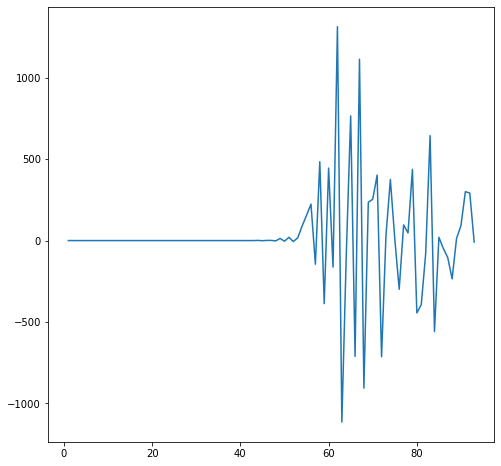

In [42]:
d = cases2
x1 = np.linspace(1, d.shape[1], d.shape[1])
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.plot(x1, d[1868])
print(d.shape)
plt.show()

In [47]:
county = 1868
X = np.vstack([cases2, deaths2])
zeros = np.count_nonzero(X == 0)
r = np.random.rand(zeros)
np.place(X, X == 0, r)
print(X)

[[ 0.53331624  0.67001942  0.93499835 ... -1.          2.
  -2.        ]
 [ 0.02080057  0.45296371  0.25062797 ...  2.         -7.
   3.        ]
 [ 0.18239841  0.57742421  0.86821217 ...  0.13391811  1.
  -1.        ]
 ...
 [ 0.25630456  0.85630169  0.03090017 ...  0.33529485  0.68457754
   0.39827246]
 [ 0.68624508  0.62417771  0.09292552 ...  0.42549089  0.20505878
   0.22734037]
 [ 0.12671407  0.21955898  0.03212492 ...  0.24828602  0.4748143
   0.02863383]]


In [48]:
n = 70
X_train = X[:, :n].astype(int)
X_test = X[:, n:].astype(int)

In [49]:
print(X_train.shape, X_test.shape)

(6284, 70) (6284, 23)


In [50]:
model = VAR(X_train.T)
for i in range(9):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 0


LinAlgError: 3-th leading minor of the array is not positive definite

In [37]:
model_fitted = model.fit(3)
model_fitted.summary()

LinAlgError: 3-th leading minor of the array is not positive definite

In [235]:
forecast_input = X_train[-9:].T
fc = model_fitted.forecast(y=forecast_input, steps=14)

In [236]:
fc = fc.astype(int)
fc

array([[-1249,   117],
       [ 2301,   164],
       [-2380,  -387],
       [ 1419,   486],
       [  798,  -317],
       [-2955,   -23],
       [ 4270,   458],
       [-3418,  -712],
       [  774,   679],
       [ 3070,  -248],
       [-5930,  -373],
       [ 6492,   966],
       [-3548, -1146],
       [-1698,   793]])

In [237]:
forecast_input

array([[  155,     0],
       [  224,     0],
       [ -145,     0],
       [  484,     0],
       [ -387,    21],
       [  445,    -2],
       [ -163,     1],
       [ 1313,    12],
       [-1114,     0],
       [  -90,    -7],
       [  765,    42],
       [ -711,   -30],
       [ 1113,    15],
       [ -906,    19],
       [  235,     0],
       [  254,   -19],
       [  402,    39],
       [ -713,     4],
       [   31,    33],
       [  375,     7],
       [   10,    46],
       [ -299,    34],
       [   96,  -159],
       [   47,   303],
       [  437,  -270]])

In [238]:
predictions = np.vstack([forecast_input, fc]).T
cases_predictions = predictions[0]
deaths_predictions = predictions[1]

In [239]:
cases_predictions = untransform(cases_predictions, ct0[county], cx0[county], 0)
deaths_predictions = untransform(deaths_predictions, dt0[county], dx0[county], 0)

(41,)


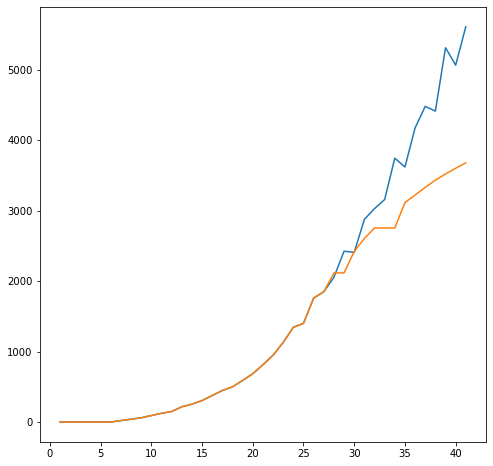

In [240]:
d = deaths_predictions
x1 = np.linspace(1, d.shape[0], d.shape[0])
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.plot(x1, d)
d2 = deaths[county]
x2 = np.linspace(1, d2.shape[0], d2.shape[0])
plt.plot(x2, d2)
print(d.shape)
plt.show()